In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to sketches folder
SKETCHES_FOLDER = 'dataset_quickdraw/sketches/sketches'

# List the first 10 .npz files (classes)
all_npz_files = sorted([f for f in os.listdir(SKETCHES_FOLDER) if f.endswith('.npz')])
#selected_npz_files = all_npz_files[:10]
selected_npz_files = all_npz_files  # Use all 350

print(f"Number of classes: {len(selected_npz_files)}")
print("Selected classes:", selected_npz_files)

# Load one .npz file (e.g., the first one)
sample_class_file = os.path.join(SKETCHES_FOLDER, selected_npz_files[0])
data = np.load(sample_class_file, allow_pickle=True, encoding='latin1')

# Display the available keys to know the contents of the npz file
print("Keys in the file:", data.files)

# Show how many sketches are in each split
for split in ['train', 'valid', 'test']:
    if split in data:
        print(f"{split.capitalize()} data shape: {data[split].shape}")


Number of classes: 345
Selected classes: ['The Eiffel Tower.npz', 'The Great Wall of China.npz', 'The Mona Lisa.npz', 'aircraft carrier.npz', 'airplane.npz', 'alarm clock.npz', 'ambulance.npz', 'angel.npz', 'animal migration.npz', 'ant.npz', 'anvil.npz', 'apple.npz', 'arm.npz', 'asparagus.npz', 'axe.npz', 'backpack.npz', 'banana.npz', 'bandage.npz', 'barn.npz', 'baseball bat.npz', 'baseball.npz', 'basket.npz', 'basketball.npz', 'bat.npz', 'bathtub.npz', 'beach.npz', 'bear.npz', 'beard.npz', 'bed.npz', 'bee.npz', 'belt.npz', 'bench.npz', 'bicycle.npz', 'binoculars.npz', 'bird.npz', 'birthday cake.npz', 'blackberry.npz', 'blueberry.npz', 'book.npz', 'boomerang.npz', 'bottlecap.npz', 'bowtie.npz', 'bracelet.npz', 'brain.npz', 'bread.npz', 'bridge.npz', 'broccoli.npz', 'broom.npz', 'bucket.npz', 'bulldozer.npz', 'bus.npz', 'bush.npz', 'butterfly.npz', 'cactus.npz', 'cake.npz', 'calculator.npz', 'calendar.npz', 'camel.npz', 'camera.npz', 'camouflage.npz', 'campfire.npz', 'candle.npz', 'cann

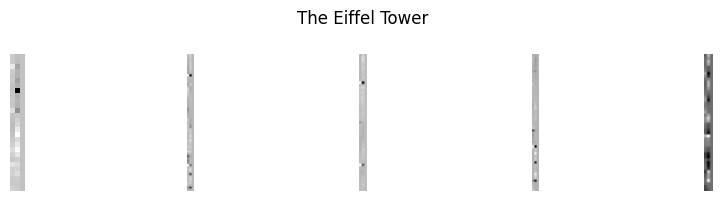

In [2]:
# 3. Visualize a few samples from the 'train' split
def plot_sketches(sketches, num=5, title='Sketch'):
    plt.figure(figsize=(10, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(sketches[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Extract 'train' sketches and plot
train_sketches = data['train']
plot_sketches(train_sketches, num=5, title=selected_npz_files[0].replace('.npz', ''))


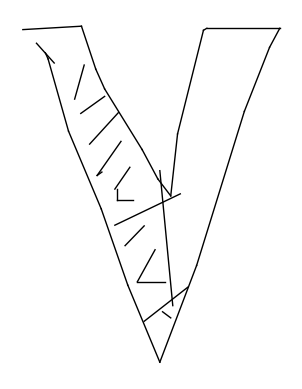

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def draw_sketch(sketch):
    """
    Draws a sketch from a stroke-3 format array of shape (n, 3).
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.axis('off')

    x, y = 0, 0
    for i in range(len(sketch)):
        dx, dy, pen = sketch[i]
        new_x, new_y = x + dx, y + dy
        if pen == 0:
            ax.plot([x, new_x], [y, new_y], 'k-', linewidth=1)
        x, y = new_x, new_y

    plt.show()

# vector data rendering, not pixel rendering
# instead of showing a 28×28 raster image, it replays the stroke movements
draw_sketch(train_sketches[10])

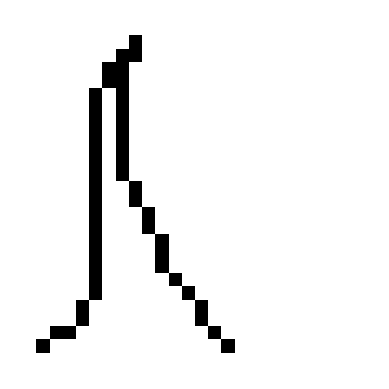

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def sketch_to_image(sketch, image_size=28, padding=2):
    """
    Converts a stroke-3 sketch to a 28x28 grayscale image.
    sketch: (n_points, 3) numpy array
    image_size: size of the output image
    padding: white padding around the sketch
    Returns: 28x28 numpy image array (dtype=float32, values between 0 and 1)
    """
    # Convert relative strokes to absolute coordinates (this conversion is very important)
    # starts from (0,0) and then adds delta x and y 
    x, y = 0, 0
    abs_coords = []
    for dx, dy, pen in sketch:
        x += dx
        y += dy
        abs_coords.append((x, y, pen))
    
    # Separate strokes into pen-down segments
    # pen-down segments are where pen == 0
    # pen-up segments are where pen == 1
    strokes = []
    current_stroke = []
    for x, y, pen in abs_coords:
        if pen == 0:
            current_stroke.append((x, y))
        elif pen == 1:
            if current_stroke:
                strokes.append(current_stroke)
                current_stroke = []
        elif pen == 2:
            break  # end of drawing
    
    if current_stroke:
        strokes.append(current_stroke)
    
    # Get bounding box for the smallest rectangle that contains strokes of image
    all_points = [pt for stroke in strokes for pt in stroke]
    xs, ys = zip(*all_points)
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    # Scale factor to fit sketch into image_size x image_size
    scale = (image_size - 2 * padding) / max(max_x - min_x, max_y - min_y + 1e-5)
    
    # Create blank image and draw strokes
    # translates each so it fits inside the bounding box with padding
    img = Image.new('L', (image_size, image_size), 'white')  # L = grayscale
    draw = ImageDraw.Draw(img)
    for stroke in strokes:
        scaled = [((x - min_x) * scale + padding, (y - min_y) * scale + padding) for x, y in stroke]
        draw.line(scaled, fill=0, width=1)
    
    return np.array(img, dtype=np.float32) / 255.0  # Normalize between 0–1


image = sketch_to_image(train_sketches[0])
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(sketches_folder, selected_classes, samples_per_class=1000):
    """
    Load and preprocess data from multiple classes
    - Defines load_and_preprocess_data function
    - Creates train/val splits
    - Prints dataset information
    """
    X = []  # store all images
    y = []  # store corresponding labels
    
    for class_idx, class_file in enumerate(selected_classes):
        # Load the .npz file
        data = np.load(os.path.join(sketches_folder, class_file), 
                      allow_pickle=True, encoding='latin1')
        
        # Get training sketches from the different splits
        sketches = data['train']
        
        # Convert first n sketches to images and appends them to x and y
        for i in range(min(samples_per_class, len(sketches))):
            image = sketch_to_image(sketches[i])
            X.append(image)
            y.append(class_idx)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Reshape to (n_samples, height, width, channels)
    X = X.reshape(-1, 28, 28, 1)    # CNNs expect a 4D tensor
    
    return X, y # returns processed arrays of images and labels


# Load and preprocess all classes
X, y = load_and_preprocess_data(SKETCHES_FOLDER, selected_npz_files)

# Create train/validation split
# stratify=y → ensures each class appears in the same proportion in both splits.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print dataset information
print("Dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

# Print class distribution
print("\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for class_idx, count in zip(unique, counts):
    print(f"{selected_npz_files[class_idx]}: {count}")

Dataset shapes:
X_train: (276000, 28, 28, 1)
X_val: (69000, 28, 28, 1)
y_train: (276000,)
y_val: (69000,)

Class distribution in training set:
The Eiffel Tower.npz: 800
The Great Wall of China.npz: 800
The Mona Lisa.npz: 800
aircraft carrier.npz: 800
airplane.npz: 800
alarm clock.npz: 800
ambulance.npz: 800
angel.npz: 800
animal migration.npz: 800
ant.npz: 800
anvil.npz: 800
apple.npz: 800
arm.npz: 800
asparagus.npz: 800
axe.npz: 800
backpack.npz: 800
banana.npz: 800
bandage.npz: 800
barn.npz: 800
baseball bat.npz: 800
baseball.npz: 800
basket.npz: 800
basketball.npz: 800
bat.npz: 800
bathtub.npz: 800
beach.npz: 800
bear.npz: 800
beard.npz: 800
bed.npz: 800
bee.npz: 800
belt.npz: 800
bench.npz: 800
bicycle.npz: 800
binoculars.npz: 800
bird.npz: 800
birthday cake.npz: 800
blackberry.npz: 800
blueberry.npz: 800
book.npz: 800
boomerang.npz: 800
bottlecap.npz: 800
bowtie.npz: 800
bracelet.npz: 800
brain.npz: 800
bread.npz: 800
bridge.npz: 800
broccoli.npz: 800
broom.npz: 800
bucket.npz: 80

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_sketch_classifier(input_shape=(28, 28, 1), num_classes=10):  # first was working with 10 classes
    """
    Creates a CNN model optimized for sketch classification
    """
    model = models.Sequential([
        # Remove the Reshape layer and fix the input shape
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Compile and train the model
def compile_and_train(model, X_train, y_train, X_val, y_val):
    """
    Compiles and trains the model with appropriate settings
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]
    )
    
    return history

In [7]:
# Create the model
#model = create_sketch_classifier(num_classes=10)  # 10 classes as per selected_npz_files
num_classes = len(selected_npz_files)
model = create_sketch_classifier(num_classes=num_classes)

model.summary()  # Display model architecture

c:\Users\Umer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 345)            │       176,985 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 862,937 (3.29 MB)

 Trainable params: 861,465 (3.29 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# Train the model
history = compile_and_train(model, X_train, y_train, X_val, y_val);

Epoch 1/30
4313/4313 ━━━━━━━━━━━━━━━━━━━━ 431s 98ms/step - accuracy: 0.2241 - loss: 3.6445 - val_accuracy: 0.4046 - val_loss: 2.5780 - learning_rate: 0.0010
Epoch 2/30
4313/4313 ━━━━━━━━━━━━━━━━━━━━ 416s 96ms/step - accuracy: 0.3505 - loss: 2.8174 - val_accuracy: 0.4633 - val_loss: 2.2646 - learning_rate: 0.0010
Epoch 3/30
4313/4313 ━━━━━━━━━━━━━━━━━━━━ 419s 97ms/step - accuracy: 0.3895 - loss: 2.6021 - val_accuracy: 0.4831 - val_loss: 2.1666 - learning_rate: 0.0010
Epoch 4/30
4313/4313 ━━━━━━━━━━━━━━━━━━━━ 442s 103ms/step - accuracy: 0.4120 - loss: 2.4865 - val_accuracy: 0.4834 - val_loss: 2.1824 - learning_rate: 0.0010
Epoch 5/30
4313/4313 ━━━━━━━━━━━━━━━━━━━━ 433s 100ms/step - accuracy: 0.4269 - loss: 2.4097 - val_accuracy: 0.5176 - val_loss: 2.0155 - learning_rate: 0.0010
Epoch 6/30
2402/4313 ━━━━━━━━━━━━━━━━━━━━ 3:03 96ms/step - accuracy: 0.4372 - loss: 2.3554

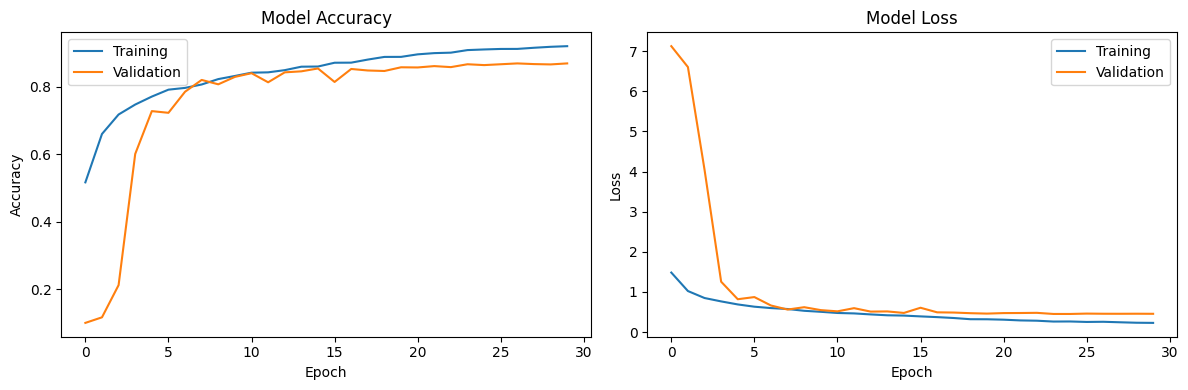

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model Evaluation:
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Test Accuracy: 0.8645


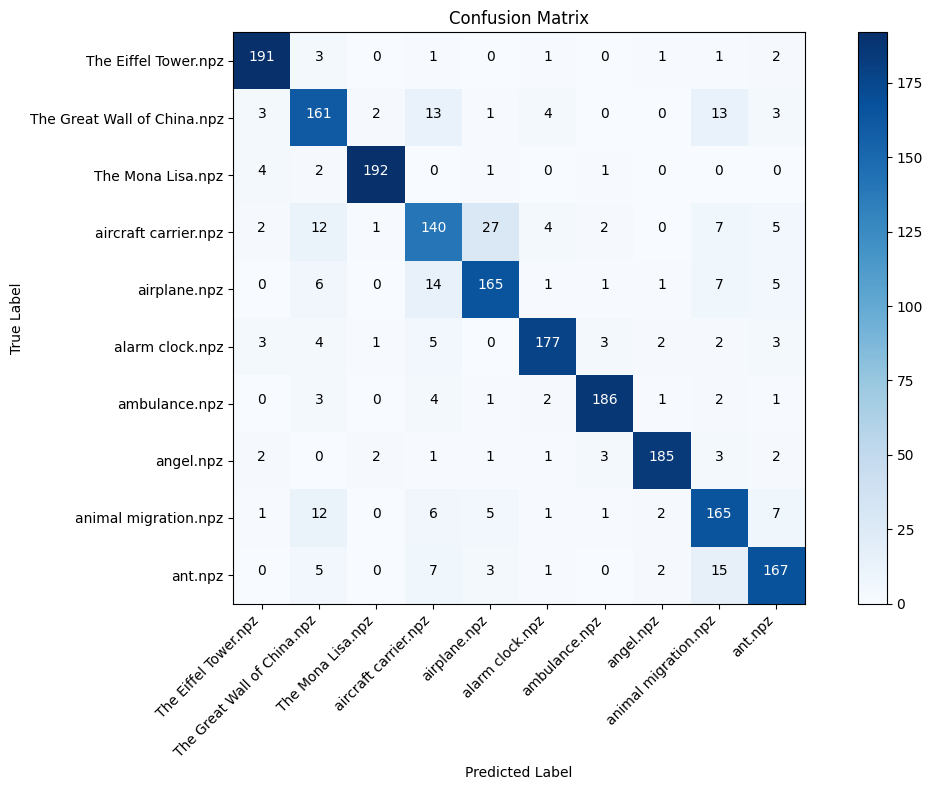


Classification Report:
                         precision    recall  f1-score   support

       The Eiffel Tower       0.93      0.95      0.94       200
The Great Wall of China       0.77      0.81      0.79       200
          The Mona Lisa       0.97      0.96      0.96       200
       aircraft carrier       0.73      0.70      0.72       200
               airplane       0.81      0.82      0.82       200
            alarm clock       0.92      0.89      0.90       200
              ambulance       0.94      0.93      0.94       200
                  angel       0.95      0.93      0.94       200
       animal migration       0.77      0.82      0.80       200
                    ant       0.86      0.83      0.85       200

               accuracy                           0.86      2000
              macro avg       0.87      0.86      0.86      2000
           weighted avg       0.87      0.86      0.86      2000


Testing with unseen data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/ste

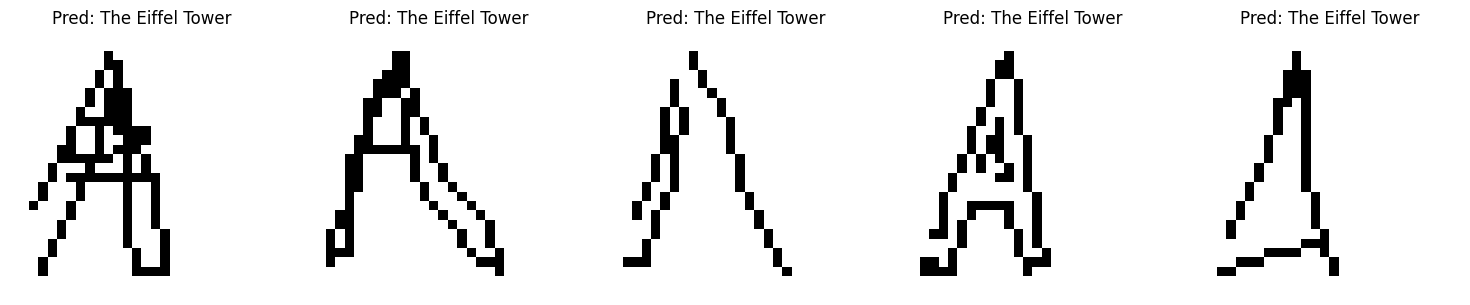

In [ ]:
def evaluate_model(model, X_test, y_test, class_names):
    """
    Comprehensive model evaluation
    """
    # Get model predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy
    test_accuracy = np.mean(y_pred_classes == y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred_classes)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add class labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    
    # Add numbers to confusion matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, 
                              target_names=[name.replace('.npz', '') for name in class_names]))

# Test with unseen data
def test_with_unseen_data(model, sketches_folder, class_name, num_samples=5):
    """
    Test model with unseen data from a specific class
    """
    # Load test data
    data = np.load(os.path.join(sketches_folder, class_name), 
                  allow_pickle=True, encoding='latin1')
    test_sketches = data['test'][:num_samples]
    
    # Convert sketches to images
    test_images = []
    for sketch in test_sketches:
        img = sketch_to_image(sketch)
        test_images.append(img)
    
    # Convert to numpy array and reshape
    X_test_unseen = np.array(test_images).reshape(-1, 28, 28, 1)
    
    # Get predictions
    predictions = model.predict(X_test_unseen)
    pred_classes = np.argmax(predictions, axis=1)
    
    # Plot results
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(test_images[i], cmap='gray')
        plt.title(f'Pred: {selected_npz_files[pred_classes[i]].replace(".npz", "")}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Evaluate the model
print("Model Evaluation:")
evaluate_model(model, X_val, y_val, selected_npz_files)

# Test with unseen data from a specific class
print("\nTesting with unseen data:")
test_with_unseen_data(model, SKETCHES_FOLDER, selected_npz_files[0])  # Test first class

In [ ]:
# Save the trained model
model_save_path = 'sketch_classifier3.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to sketch_classifier.h5
